Import

In [1]:

%load_ext autoreload
%autoreload 2

from model import Net
from dataloader import *
from dataloader_utils import *
from yolo_utils import *
from loss import *

import matplotlib.pyplot as plt
import numpy as np
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ['PYDEVD_DISABLE_FILE_VALIDATION'] = '1'
import torch
import sys
sys.argv.append("-Xfrozen_modules=off")

%matplotlib inline


Load data

In [2]:
dataloader = DataLoader()
dataloader.load_data(max_file=100)

Loading data...
Loading data done.
Train set size:  100
Test set size:  0


Show data

original image size: (331, 500, 3)
[{'xmin': 168, 'ymin': 41, 'xmax': 325, 'ymax': 234, 'cx': 0.493, 'cy': 0.41540785498489424, 'w': 0.314, 'h': 0.5830815709969789, 'width': 500, 'height': 331, 'class': 'person', 'confidence': 1}, {'xmin': 143, 'ymin': 101, 'xmax': 331, 'ymax': 258, 'cx': 0.474, 'cy': 0.5422960725075529, 'w': 0.376, 'h': 0.4743202416918429, 'width': 500, 'height': 331, 'class': 'motorbike', 'confidence': 1}]


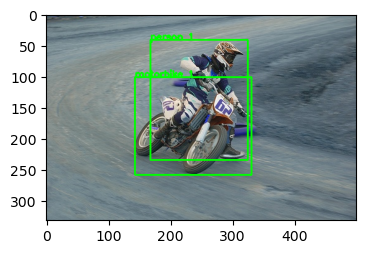

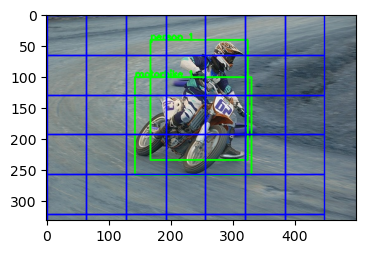

(448, 448, 3)
(1, 7, 7, 30)
[0.3125     0.6796875  0.375      0.31473213 1.         0.3125
 0.6796875  0.375      0.31473213 1.         0.         0.
 0.         0.         0.         0.         0.         1.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]
[{'cx': 0.4732142857142857, 'cy': 0.5256696428571429, 'w': 0.375, 'h': 0.31473213, 'class': 'motorbike', 'confidence': 1.0, 'width': 448, 'height': 448, 'xmin': 128, 'ymin': 165, 'xmax': 296, 'ymax': 305}]
[{'cx': 0.4732142857142857, 'cy': 0.5256696428571429, 'w': 0.375, 'h': 0.31473213, 'class': 'motorbike', 'confidence': 1.0, 'width': 448, 'height': 448, 'xmin': 128, 'ymin': 165, 'xmax': 296, 'ymax': 305}]


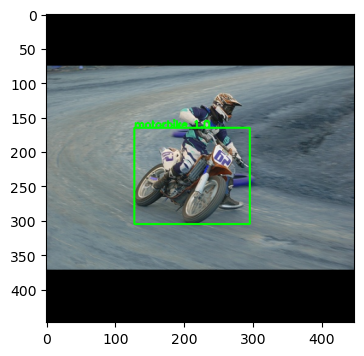

In [8]:
np.random.seed(42)

# randomly select an image
idx = np.random.randint(len(dataloader.train_images))
# make sure idx is not out of bound
idx = max(0, min(idx, len(dataloader.train_images) - 1))
image = dataloader.train_labels[idx]["original_image"]
original_image = image.copy()
original_boxes = dataloader.train_labels[idx]["original_boxes"]

# plot original image
print("original image size:", original_image.shape)
print(original_boxes)
original_image = plot_bbox_on_image(original_image, original_boxes)
plt.figure(figsize=(4, 4))
plt.imshow(original_image)

# plot the image
image = dataloader.train_images[idx]
boxes = dataloader.train_labels[idx]["boxes"]
plot_image = image.copy()
plot_boxes = copy.deepcopy(boxes)
plot_images, plot_boxes = image_resize2sq(plot_image, plot_boxes)
plot_image = plot_bbox_on_image(plot_image, boxes)
plt.figure(figsize=(4, 4))
plt.imshow(plot_image)

# mark the grids of the image
grid_size = INPUT_SIDE / N_GRID_SIDE
for i in range(N_GRID_SIDE):
    for j in range(N_GRID_SIDE):
        rect = plt.Rectangle((i * grid_size, j * grid_size), grid_size, grid_size, fill=False, edgecolor="blue", linewidth=1)
        plt.gca().add_patch(rect)

plt.show()

# show the non-zero numbers of the label
image, label = dataloader.pull_item(idx)
label = label.reshape(1, N_GRID_SIDE, N_GRID_SIDE, 30)
print(image.shape)
print(label.shape)
for i in range(N_GRID_SIDE):
    for j in range(N_GRID_SIDE):
        if label[0, i, j, 4] != 0:
            print(label[0, i, j, :])

# label2boxes
label = label.reshape(N_GRID_SIDE, N_GRID_SIDE, 30)
pred_boxes = label2box(label)
print(pred_boxes)
pred_boxes = non_max_suppression(pred_boxes)
print(pred_boxes)

# plot the image
image = plot_bbox_on_image(image, pred_boxes)
plt.figure(figsize=(4, 4))
plt.imshow(image)


Test yolo utils

In [9]:
batch_size = BATCH_SIZE
train_lab = [0.5, 0.5, 0.5, 0.5, 1, 0.5, 0.5, 0.5, 0.5, 1]
# Train labels are zeros, except for the first grid cell
train_label = np.zeros((batch_size, N_GRID_SIDE, N_GRID_SIDE, 5 * N_BBOX + N_CLASSES))
train_label[0, 0, 0, :10] = train_lab
train_label = torch.from_numpy(train_label).float()

train_forward = torch.zeros((batch_size, N_GRID_SIDE, N_GRID_SIDE, 5 * N_BBOX + N_CLASSES))

loss = yolo_loss_be(train_forward, train_label)
print(loss)
loss2 = yolo_loss_be(train_label, train_label)
print(loss2)



tensor(3.2812)
tensor(0.)


Test model.

In [14]:
train_images, train_labels = next(dataloader.get_train_batch())
net = Net(device="cpu")

# Test forward
train_images = torch.from_numpy(train_images).float()
train_labels = torch.from_numpy(train_labels).float()
train_images = train_images.permute(0, 3, 1, 2)
train_labels = train_labels.reshape(-1, N_GRID_SIDE, N_GRID_SIDE, 30)
forward = net.forward(train_images)
print("Forward shape: ", forward.shape)
print("Label shape: ", train_labels.shape)
 
loss = yolo_loss_be(forward, train_labels)
print(loss)


Forward shape:  torch.Size([32, 7, 7, 30])
Label shape:  torch.Size([32, 7, 7, 30])
tensor(46.0737, grad_fn=<DivBackward0>)


test Train

In [ ]:
train = Train()

Load Weight.

In [16]:
net = Net()
net.load_weights("weights135-1220.pth")

RuntimeError: Error(s) in loading state_dict for Net:
	Missing key(s) in state_dict: "yolo_neck.0.weight", "yolo_neck.0.bias", "yolo_neck.1.weight", "yolo_neck.1.bias", "yolo_neck.1.running_mean", "yolo_neck.1.running_var", "yolo_neck.3.weight", "yolo_neck.3.bias", "yolo_neck.4.weight", "yolo_neck.4.bias", "yolo_neck.4.running_mean", "yolo_neck.4.running_var", "yolo_neck.6.weight", "yolo_neck.6.bias", "yolo_neck.7.weight", "yolo_neck.7.bias", "yolo_neck.7.running_mean", "yolo_neck.7.running_var", "yolo_neck.9.weight", "yolo_neck.9.bias", "yolo_neck.10.weight", "yolo_neck.10.bias", "yolo_neck.10.running_mean", "yolo_neck.10.running_var", "yolo_head.0.weight", "yolo_head.0.bias", "yolo_head.1.weight", "yolo_head.1.bias", "yolo_head.1.running_mean", "yolo_head.1.running_var", "yolo_head.3.weight", "yolo_head.3.bias", "yolo_head.4.weight", "yolo_head.4.bias", "yolo_head.4.running_mean", "yolo_head.4.running_var". 
	Unexpected key(s) in state_dict: "yolo_tail.0.weight", "yolo_tail.0.bias", "yolo_tail.1.weight", "yolo_tail.1.bias", "yolo_tail.1.running_mean", "yolo_tail.1.running_var", "yolo_tail.1.num_batches_tracked", "yolo_tail.3.weight", "yolo_tail.3.bias", "yolo_tail.4.weight", "yolo_tail.4.bias", "yolo_tail.4.running_mean", "yolo_tail.4.running_var", "yolo_tail.4.num_batches_tracked", "yolo_tail.6.weight", "yolo_tail.6.bias", "yolo_tail.7.weight", "yolo_tail.7.bias", "yolo_tail.7.running_mean", "yolo_tail.7.running_var", "yolo_tail.7.num_batches_tracked", "yolo_tail.9.weight", "yolo_tail.9.bias", "yolo_tail.10.weight", "yolo_tail.10.bias", "yolo_tail.10.running_mean", "yolo_tail.10.running_var", "yolo_tail.10.num_batches_tracked", "fcs.0.weight", "fcs.0.bias", "fcs.2.weight", "fcs.2.bias". 

compute map. visualize the result.

In [4]:

# Test predict
import torch

# Visualize the prediction

# Test on train images
train_images = dataloader.train_images[:20]
train_boxes = [msg["boxes"] for msg in dataloader.train_msg[:20]]
train_labels = dataloader.train_labels[:20]
train_labels = torch.Tensor(train_labels).float()
train_labels = train_labels.reshape(-1, N_GRID_SIDE, N_GRID_SIDE, 5 * N_BBOX + N_CLASSES)
train_images = np.array(train_images)
original_train_images = train_images
pred_labels = net.forward(torch.Tensor(train_images).float().permute(0, 3, 1, 2))
boxes = net.predict(train_images)

# print pred label and gt label
# find where the label is not zero
print(yolo_loss(pred_labels, train_labels))




C:\Users\hw\AppData\Local\Temp\ipykernel_4508\3984523571.py:10: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:264.)
  train_labels = torch.Tensor(train_labels).float()


tensor(0.1002, grad_fn=<DivBackward0>)


tensor([0.5938, 0.3672, 0.4062, 0.4040, 1.0000, 0.5938, 0.3672, 0.4062, 0.4040,
        1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000])
tensor([0.6110, 0.4099, 0.4040, 0.4057, 0.9133, 0.8032, 0.2063, 0.0140, 0.0276,
        0.0020, 0.0065, 0.0070, 0.0042, 0.0065, 0.0076, 0.0042, 0.0143, 0.0011,
        0.0054, 0.9867, 0.0078, 0.0098, 0.0016, 0.0172, 0.0053, 0.0024, 0.0027,
        0.0104, 0.0066, 0.0018], grad_fn=<SliceBackward0>)


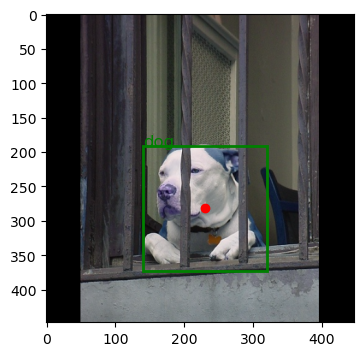

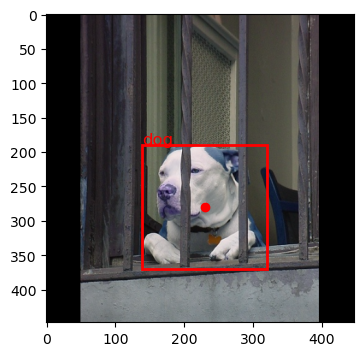

In [5]:
idx = 6
for i in range(N_GRID_SIDE):
    for j in range(N_GRID_SIDE):
        if train_labels[idx][i, j, 4] > 0:
            print(train_labels[idx][i, j, :])
            print(pred_labels[idx][i, j, :])

plt.figure(figsize=(4, 4))
plt.imshow(original_train_images[idx])
for box in boxes[idx]:
    xmin = box["xmin"]
    ymin = box["ymin"]
    xmax = box["xmax"]
    ymax = box["ymax"]
    # plot bounding box, a rectangle
    rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, edgecolor="green", linewidth=2)
    plt.gca().add_patch(rect)
    plt.text(xmin, ymin, box["class"], color="green", fontsize=12)
    # plot the center of the bounding box
    plt.plot((xmin + xmax) / 2, (ymin + ymax) / 2, "ro")

plt.show()
# plot ground truth
plt.figure(figsize=(4, 4))
plt.imshow(original_train_images[idx])
for box in train_boxes[idx]:
    xmin = box["xmin"]
    ymin = box["ymin"]
    xmax = box["xmax"]
    ymax = box["ymax"]
    # plot bounding box, a rectangle
    rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, edgecolor="red", linewidth=2)
    plt.gca().add_patch(rect)
    plt.text(xmin, ymin, box["class"], color="red", fontsize=12)
    # plot the center of the bounding box
    plt.plot((xmin + xmax) / 2, (ymin + ymax) / 2, "ro")




In [7]:
import sys
sys.argv.append("-Xfrozen_modules=off")

# Test images
test_images = dataloader.test_images
test_images = np.array(test_images)
original_test_images = test_images
print(test_images.shape)
test_boxes = [msg["boxes"] for msg in dataloader.test_msg]
mAP = net.evaluate(test_images, test_boxes)
test_images = test_images[0:32]
test_boxes = test_boxes[0:32]
boxes_ = net.predict(test_images)
print(mAP)


(173, 448, 448, 3)


: 

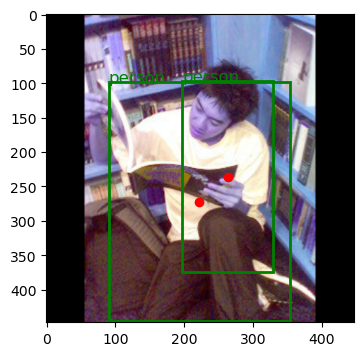

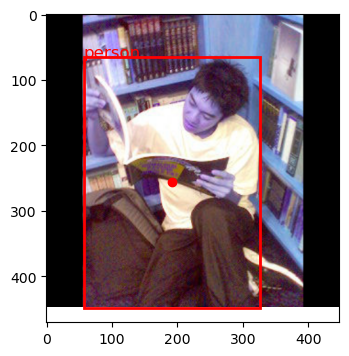

In [22]:
idx = 16

plt.figure(figsize=(4, 4))
plt.imshow(original_test_images[idx])
for box in boxes_[idx]:
    xmin = box["xmin"]
    ymin = box["ymin"]
    xmax = box["xmax"]
    ymax = box["ymax"]
    # plot bounding box, a rectangle
    rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, edgecolor="green", linewidth=2)
    plt.gca().add_patch(rect)
    plt.text(xmin, ymin, box["class"], color="green", fontsize=12)
    # plot the center of the bounding box
    plt.plot((xmin + xmax) / 2, (ymin + ymax) / 2, "ro")

plt.show()

# plot ground truth
plt.figure(figsize=(4, 4))
plt.imshow(original_test_images[idx])
for box in test_boxes[idx]:
    xmin = box["xmin"]
    ymin = box["ymin"]
    xmax = box["xmax"]
    ymax = box["ymax"]
    # plot bounding box, a rectangle
    rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, edgecolor="red", linewidth=2)
    plt.gca().add_patch(rect)
    plt.text(xmin, ymin, box["class"], color="red", fontsize=12)
    # plot the center of the bounding box
    plt.plot((xmin + xmax) / 2, (ymin + ymax) / 2, "ro")

plt.show()